In [1]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('CPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.0
Num GPUs: 1


In [2]:
import pyodbc
import yfinance as yf
import pandas as pd
from sqlalchemy import create_engine
import datetime
from datetime import date, timedelta

# Verbindungsstring
conn_str = (
    r'Driver=SQL Server;'
    r'Server=.\SQLEXPRESS;'
    r'Database=studienprojekt;'
    r'Trusted_Connection=yes;'
)

# Verbindung zur Datenbank herstellen
cnxn = pyodbc.connect(conn_str)

# SQLAlchemy connectable erstellen
engine = create_engine('mssql+pyodbc://', creator=lambda: cnxn)

# Tabelle prüfen
table_name = "stock_data"  # Name der Zieltabelle
start_date = "2021-07-01"  # Startdatum, ab dem Daten überprüft werden sollen
end_date = "2023-07-01"  # Enddatum, bis zu dem Daten überprüft werden sollen
company_name = "GOOG"  # nur AAPL, MSFT oder GOOG möglich // Name des Unternehmens, für das Daten geladen werden sollen

# Daten aus der Tabelle für das bestimmte Unternehmen in einen DataFrame laden
select_query = f"SELECT * FROM {table_name} WHERE date >= ? AND date <= ? AND Company = ?"
data = pd.read_sql(select_query, con=engine, params=(start_date, end_date, company_name))

# added
data["ID"] = data.index
data = data[["Date", "Company", "Type", "Open", "High", "Low", "Close", "Volume"]]
data.reset_index(drop=True, inplace=True)

# Verbindung schließen
cnxn.close()

# DataFrame anzeigen
print(data.tail())


          Date Company Type        Open        High         Low       Close  \
498 2023-06-26    GOOG  ACT  121.466003  122.720001  118.989998  119.089996   
499 2023-06-27    GOOG  ACT  117.839996  119.894997  116.910004  119.010002   
500 2023-06-28    GOOG  ACT  117.959999  121.269997  117.599998  121.080002   
501 2023-06-29    GOOG  ACT  120.089996  120.910004  119.209999  120.010002   
502 2023-06-30    GOOG  ACT  121.099998  122.029999  120.879997  120.970001   

       Volume  
498  23185000  
499  27221700  
500  19753100  
501  18517500  
502  23865800  


In [3]:
df = data

In [4]:
df.drop("Company", axis=1, inplace=True)
df.drop("Type", axis=1, inplace=True)
df.set_index("Date", inplace=True)

In [5]:
df


,Open,High,Low,Close,Volume
Date,,,,,
2021-07-01,124.849747,126.462502,124.849747,126.368500,17120000
2021-07-02,126.839500,128.848007,126.768997,128.718994,21160000
2021-07-06,129.449493,129.884506,128.408997,129.770996,21350000
2021-07-07,130.341003,130.639893,129.759995,130.077499,16680000
2021-07-08,128.250000,130.032501,128.039993,129.177002,19780000
...,...,...,...,...,...
2023-06-26,121.466003,122.720001,118.989998,119.089996,23185000
2023-06-27,117.839996,119.894997,116.910004,119.010002,27221700
2023-06-28,117.959999,121.269997,117.599998,121.080002,19753100


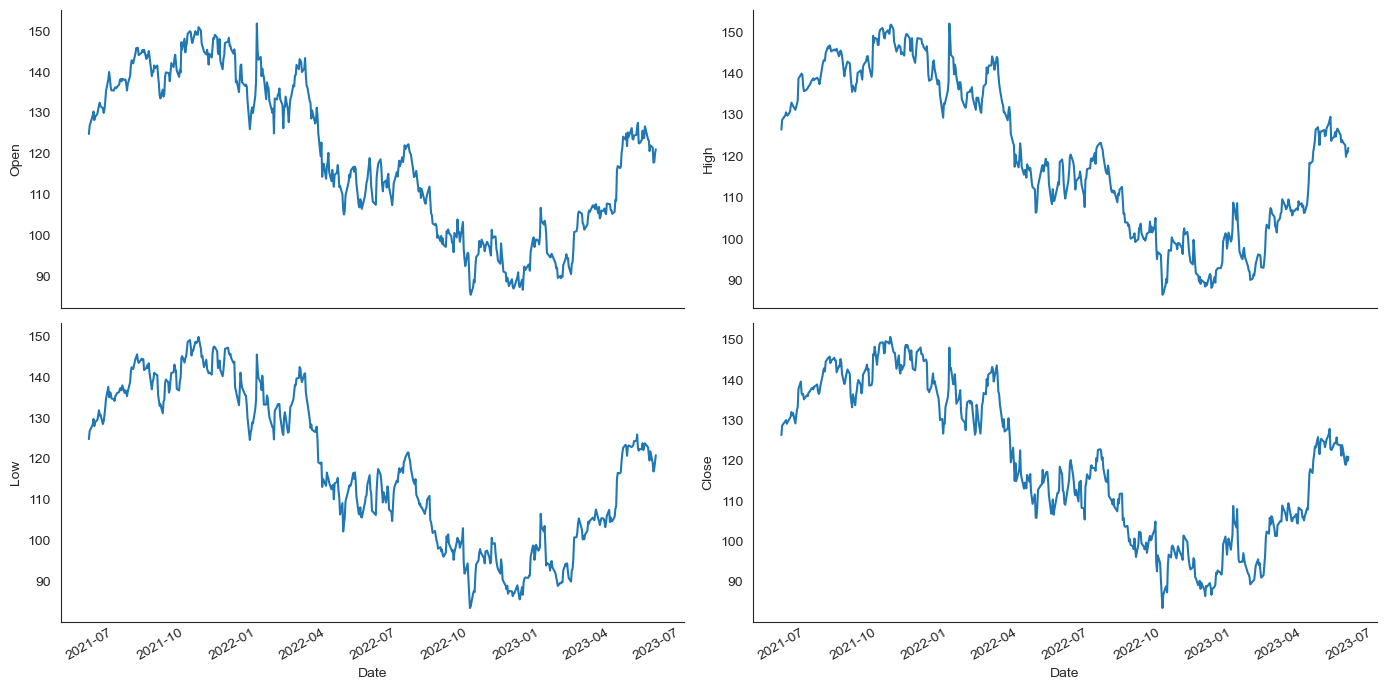

In [6]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [7]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-06-26,122.720001,118.989998,121.466003,119.089996,23185000,119.089996
2023-06-27,119.894997,116.910004,117.839996,119.010002,27221700,119.010002
2023-06-28,121.269997,117.599998,117.959999,121.080002,19753100,121.080002
2023-06-29,120.910004,119.209999,120.089996,120.010002,18517500,120.010002
2023-06-30,122.029999,120.879997,121.099998,120.970001,23865800,120.970001


In [8]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(503, 5)


In [9]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(353, 50, 5) (353,)
(100, 50, 5) (100,)
0.8922328046363617
0.8922328046363617


In [10]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
np_data_columns = data.columns.tolist()
index_Close = np_data_columns.index("Close")

# Split the training data into train and test data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) # contains sequence_length values 0-sequence_length * columns
        y.append(data[i, index_Close]) # contains the prediction values for validation, for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


(353, 50, 5) (353,)
(100, 50, 5) (100,)
0.8922328046363617
0.8922328046363617


In [11]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [12]:
# Training the model
epochs = 5
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/5
23/23 [==============================] - 18s 588ms/step - loss: 0.0255 - val_loss: 0.0077
Epoch 2/5
23/23 [==============================] - 11s 458ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 3/5
23/23 [==============================] - 11s 460ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 4/5
23/23 [==============================] - 10s 415ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 5/5
23/23 [==============================] - 11s 477ms/step - loss: 0.0048 - val_loss: 0.0030


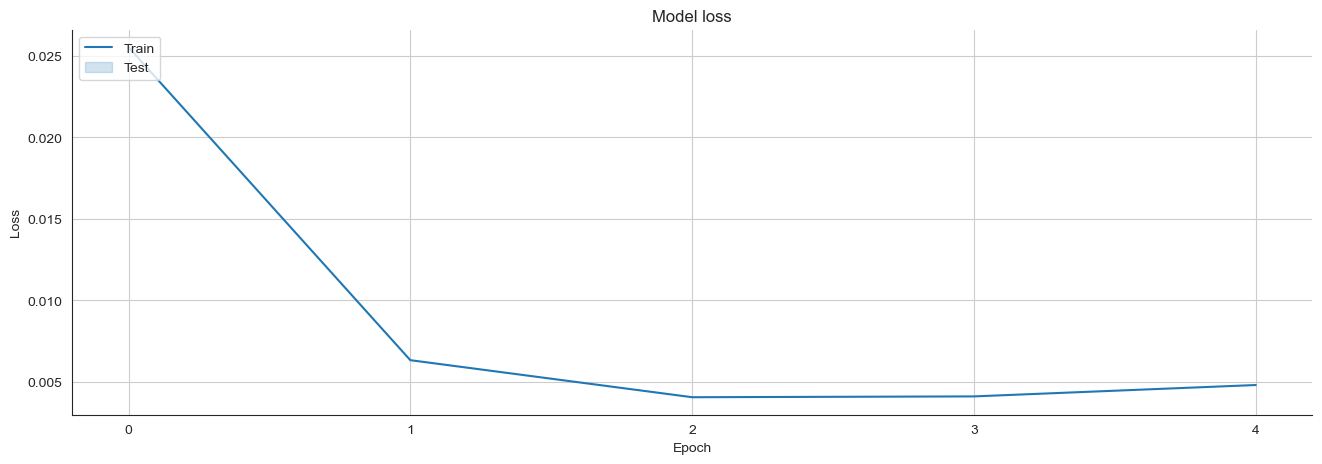

In [13]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [14]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

4/4 [==============================] - 1s 21ms/step
Median Absolute Error (MAE): 2.86
Mean Absolute Percentage Error (MAPE): 2.71 %
Median Absolute Percentage Error (MDAPE): 1.96 %


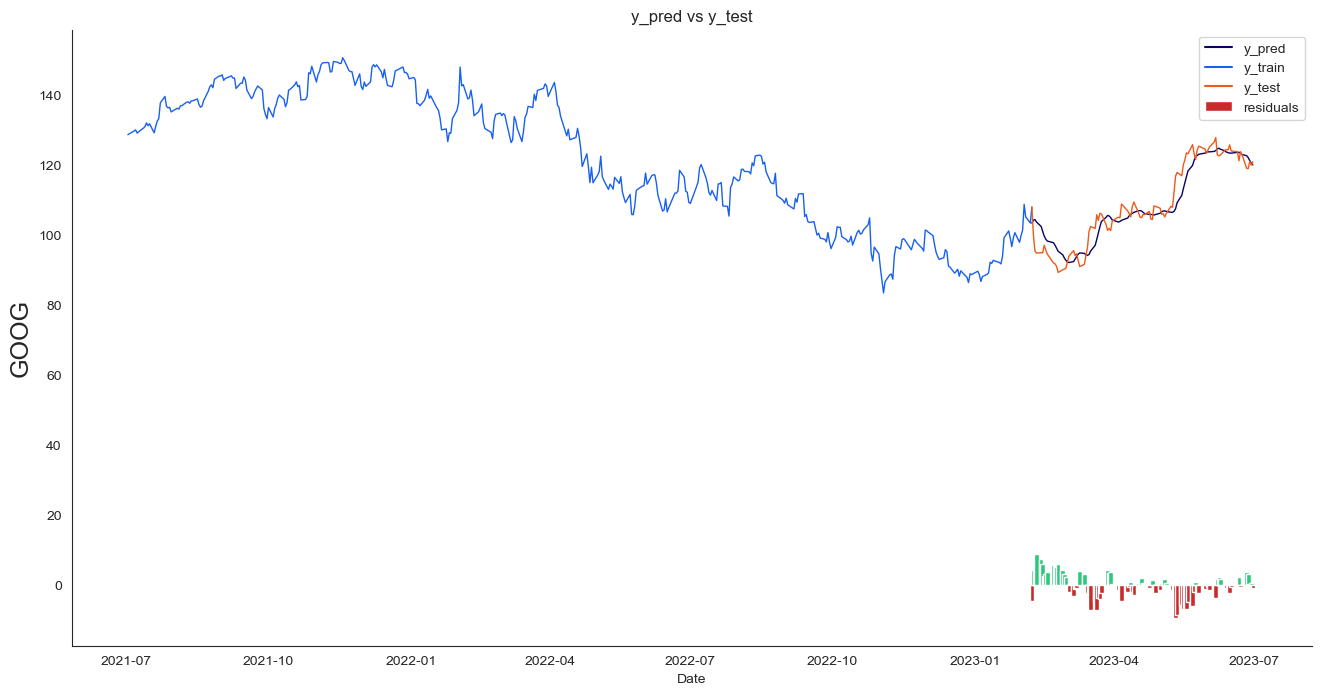

In [15]:
# The date from which on the date is displayed
display_start_date = start_date 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(company_name, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

In [16]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {company_name} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 31ms/step
The close price for GOOG at 2023-07-01 was 120.97
The predicted close price is 119.93000030517578 (-0.87%)


In [17]:
# Anzahl der nächsten Tage, die vorhergesagt werden sollen
num_days = 30

# Vorhersage für jeden Tag treffen
for _ in range(num_days):
    # Aktuelle letzten N Tage abrufen und skalieren
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Leere Liste erstellen und vergangene N Tage hinzufügen
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # X_test in ein Numpy-Array umwandeln und Daten umformen
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    # Vorhersage der nächsten 30 Tage speichern
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    
    # Datum für den nächsten Tag berechnen
    next_day = new_df.index[-1] + pd.DateOffset(days=1)
    
    # Aktuelle Vorhersage ausdrucken
    print(f'The predicted close price for {company_name} on {next_day} is {predicted_price}')
    
    # Vorhersage zum neuen DataFrame hinzufügen
    new_df.loc[next_day] = predicted_price
    
    # Aktuellen Tag aus dem DataFrame entfernen
    new_df = new_df[1:]


1/1 [==============================] - 0s 31ms/step
The predicted close price for GOOG on 2023-07-01 00:00:00 is 119.93000030517578
1/1 [==============================] - 0s 30ms/step
The predicted close price for GOOG on 2023-07-02 00:00:00 is 119.75
1/1 [==============================] - 0s 28ms/step
The predicted close price for GOOG on 2023-07-03 00:00:00 is 119.5199966430664
1/1 [==============================] - 0s 30ms/step
The predicted close price for GOOG on 2023-07-04 00:00:00 is 119.2300033569336
1/1 [==============================] - 0s 30ms/step
The predicted close price for GOOG on 2023-07-05 00:00:00 is 118.9000015258789
1/1 [==============================] - 0s 30ms/step
The predicted close price for GOOG on 2023-07-06 00:00:00 is 118.5199966430664
1/1 [==============================] - 0s 30ms/step
The predicted close price for GOOG on 2023-07-07 00:00:00 is 118.11000061035156
1/1 [==============================] - 0s 30ms/step
The predicted close price for GOOG on 20

In [18]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-01,124.849747,126.462502,124.849747,126.368500,17120000
2021-07-02,126.839500,128.848007,126.768997,128.718994,21160000
2021-07-06,129.449493,129.884506,128.408997,129.770996,21350000
2021-07-07,130.341003,130.639893,129.759995,130.077499,16680000
2021-07-08,128.250000,130.032501,128.039993,129.177002,19780000
...,...,...,...,...,...
2023-06-26,121.466003,122.720001,118.989998,119.089996,23185000
2023-06-27,117.839996,119.894997,116.910004,119.010002,27221700
2023-06-28,117.959999,121.269997,117.599998,121.080002,19753100


In [19]:
import pandas as pd
import numpy as np

# Anzahl der nächsten Tage, die vorhergesagt werden sollen
num_days = 30

# Vorhersage für jeden Tag treffen und zum DataFrame hinzufügen
for _ in range(num_days):
    # Aktuelle letzten N Tage abrufen und skalieren
    last_N_days = new_df[-sequence_length:].values
    last_N_days_scaled = scaler.transform(last_N_days)
    
    # Leere Liste erstellen und vergangene N Tage hinzufügen
    X_test_new = []
    X_test_new.append(last_N_days_scaled)
    
    # X_test in ein Numpy-Array umwandeln und Daten umformen
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    
    # Vorhersage der nächsten 30 Tage speichern
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    
    # Datum für den nächsten Tag berechnen
    next_day = new_df.index[-1] + pd.DateOffset(days=1)
    
    # Vorhersage zum DataFrame hinzufügen
    df.loc[next_day, 'Predicted Price'] = predicted_price
    
    # Neuen Tag zum new_df DataFrame hinzufügen
    new_df.loc[next_day] = predicted_price
    
    # Aktuellen Tag aus dem DataFrame entfernen
    new_df = new_df[1:]


1/1 [==============================] - 0s 38ms/step


In [20]:
new_df

,High,Low,Open,Close,Volume
Date,,,,,
2023-07-11,116.139999,116.139999,116.139999,116.139999,116.139999
2023-07-12,115.610001,115.610001,115.610001,115.610001,115.610001
2023-07-13,115.059998,115.059998,115.059998,115.059998,115.059998
2023-07-14,114.510002,114.510002,114.510002,114.510002,114.510002
2023-07-15,113.949997,113.949997,113.949997,113.949997,113.949997
2023-07-16,113.400002,113.400002,113.400002,113.400002,113.400002
2023-07-17,112.849998,112.849998,112.849998,112.849998,112.849998
2023-07-18,112.300003,112.300003,112.300003,112.300003,112.300003
2023-07-19,111.750000,111.750000,111.750000,111.750000,111.750000


In [21]:
# Den DataFrame "new_df" an den DataFrame "df" anhängen
df_extended = pd.concat([df, new_df])

# Die indexwerte neu zuordnen
#df_extended.set_index("Date", inplace=True)


In [22]:
df_extended

,Open,High,Low,Close,Volume,Predicted Price
Date,,,,,,
2021-07-01,124.849747,126.462502,124.849747,126.368500,1.712000e+07,NaN
2021-07-02,126.839500,128.848007,126.768997,128.718994,2.116000e+07,NaN
2021-07-06,129.449493,129.884506,128.408997,129.770996,2.135000e+07,NaN
2021-07-07,130.341003,130.639893,129.759995,130.077499,1.668000e+07,NaN
2021-07-08,128.250000,130.032501,128.039993,129.177002,1.978000e+07,NaN
...,...,...,...,...,...,...
2023-08-25,95.099998,95.099998,95.099998,95.099998,9.510000e+01,NaN
2023-08-26,94.720001,94.720001,94.720001,94.720001,9.472000e+01,NaN
2023-08-27,94.349998,94.349998,94.349998,94.349998,9.435000e+01,NaN


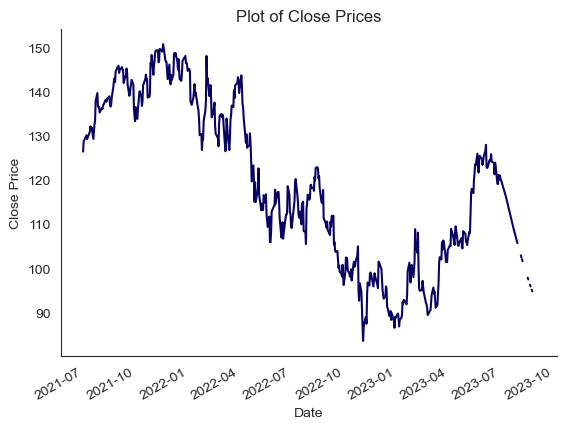

In [23]:
import matplotlib.pyplot as plt

# Plotting the "Close" column
df_extended["Close"].plot()

# Adding labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Plot of Close Prices")

# Displaying the plot
plt.show()
